# CAVI for 2D Mixture of Gaussians
This notebook holds the implementation for an extension of the Coordinate Ascent Variation Inference algorithm dscribed in the paper "variational inference: a review for statisticians" by Blei et al. 
First, a brief introduction about the variational inference will be given, followed by the implementation of the CAVI, including appropriate visualizations

In [1]:
from IPython.core.display import HTML

## Background
### Variational Inference
Variational inference belongs to the field of Bayesian inference, where the aim is to estimate the posterior of a latent variable of interest.
In principle, VI posits a family of prior densities, and optimizes for the most similar member of that family to the distribution of interest, where similarity is measured by the Kullback-Liebler divergence:
\begin{equation}\label{eq:viBase}
    \hat{q}(z) = \underset{q(z)\in \mathcal{D}}{argmin}KL(q(z)||p(z|x))
\end{equation}
<center><img src='Figs/VI.png'></center>

#### ELBO
Simplifying the term for the optimization objective of the VI, we get:
\begin{equation}
    KL(q(z)||p(z|x)) = \mathbb{E}[log(q(z))] - \mathbb{E}[log(p(z, x))] + log(p(x)) \geq 0
\end{equation}
Where the last transition follows since the KL divergence is non-negative. Hence:
\begin{equation}
    log(p(x)) \geq  \mathbb{E}[log(p(z, x))] - \mathbb{E}[log(q(z))] \triangleq ELBO(q)
\end{equation}
Which is the evidence ($log(p(x))$) lower bound (ELBO). Thus, maximizing the ELBO is equivalent to minimizing the KL divergence, which is our objective

#### CAVI
The coordinate-ascent-variational-inference algorithm attempts to maximize the ELBO under the assumption of a mean-field variational family, i.e. $q(z) = \prod_{j=1}^mq_j(z_j)$.
It performs the optimization iteratively in a pareto-fashion, i.e. optimizes each factor of the variational density while keeping the others fixed. The CAVI algorithm is as follows:

Given a dataset $x$ and a joint distribution model $p(x,z)$:
1. Initialize $q_j(z_j)$
2. While ELBO hasn't converged:
    1. $q_j(z_j)\gets exp\{\mathbb{E}_{-j}[log(p(z_j|z_{-j}, x))]\}$
    2. Compute $ELBO(q) = \mathbb{E}[log(p(z,x))] - \mathbb{E}[log(q(z))]$


## Implementation

In [2]:
from utils import getMogData, to_numpy, plotCaviIter, makeGif
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

font = {'size': 16}
matplotlib.rc('font', **font)
matplotlib.rc('figure', **{"figsize": (19.2, 9.77), "autolayout": True})


### GMM
Considering the case of mixture of K Gaussians, all of a unit-variance, where the means of the Gaussians $\mu_k$ are latent variables drawn themselves from a Gaussian distribution with some variance $\sigma^2$ which in our case is a nuisance parameter. The setup can hence be formulated by the following:

\begin{equation}
    \begin{split}
        \mu_k &\sim \mathcal{N}(0, \sigma^2) \\
        c_i &\sim Unif_{[1, K]} \\
        x_i|c_i, \mu &\sim \mathcal{N}(c_i^T\mu, 1)
    \end{split}
\end{equation}

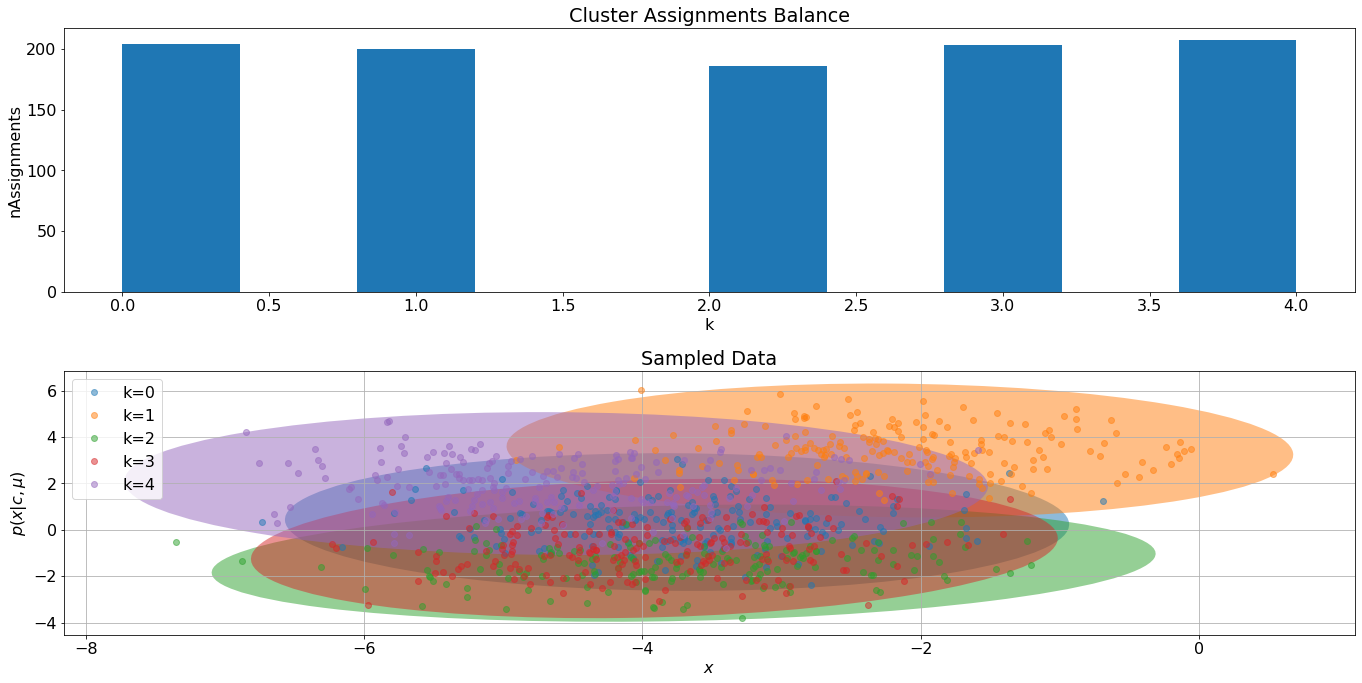

In [3]:
# Hyper Parameters for the GMM data generation:
K = 5
sigma = 3
nSamples = 1000

samples = getMogData(K=K, sigma=sigma, nSamples=nSamples, debug=True)


## CAVI for 2D Mixture of Gaussians

### ELBO Calculation

\begin{equation}
\begin{split}
    ELBO(m, s^2, \phi) &= \sum_{k=1}^K\mathbb{E}[\log p(\mu_k; m_k, s_k^2)] -
    \mathbb{E}[\log q(\mu_k; m_k, s_k^2)] \\
    &+\sum_{j=1}^n\mathbb{E}[\log p(c_j; \varphi_j)]
    - \mathbb{E}[\log q(c_j; \varphi_j)]
    + \mathbb{E}[\log p(x_j; \varphi_j, m, s^2)]
\end{split}
\end{equation}


In [4]:
def calcElbo(x: np.ndarray, sigma: float, m_hat: np.ndarray, s2_hat: np.ndarray, phi_hat: np.ndarray):
    """Calculates the evidence lower bound given the estimates of the latent variable's distributions

        Parameters:
            x - (n,1) array of the sampled data
            sigma - the standard deviation of the different Gaussians generator (hyper-parameter)
            m_hat - (1,K) means array of the variational Gaussians factors
            s2_hat - (1,K) variance array variational Gaussians factors
            phi_hat - (n,K) variational assignments matrix
    """
    elbo_terms = np.zeros(4)  # prepare a vector for the different elbo terms
    elbo_terms[0] = -1 / (2 * sigma ** 2) * (s2_hat + (m_hat ** 2).sum(axis=0)).sum()
    elbo_terms[1] = (phi_hat * (x @ m_hat - 0.5 * (s2_hat + (m_hat ** 2)).sum(axis=0))).sum()
    elbo_terms[2] = -(phi_hat * np.log(phi_hat)).sum()
    elbo_terms[3] = -0.5 * np.log(2 * s2_hat).sum()

    return elbo_terms.sum()


### Variational Factors Update
#### Local Factors ($\varphi_i$):
\begin{equation}
\begin{split}
    q(c_i;\varphi_i) &\propto exp\{\mathbb{E}[log p(c_i, c_{-i}, \mu, x)]\} \\
    &\propto exp\{\mathbb{E}[log p(c_i) + log p(c_{-i}) + log p(\mu) + \sum_{j=1}^n log p(x_j|c_j, \mu)]\} \\
    &\propto exp\{\mathbb{E}[log p(c_i) + p(x_i|c_i, \mu)]\} = exp\{\mathbb{E}[\frac{1}{K} + p(x_i| c_i^T\cdot\mu)]\} \\
    &\propto exp\{-\frac{1}{2}\mathbb{E}[x_i^2 -2x_i\mu_{c_i} + \mu_{c_i}^2]\} \\
    &\propto exp\{x_i m_{c_i} -\frac{1}{2}(s_{c_i}^2 + \mu_{c_i}^2)\} \\
    \Rightarrow \varphi_i &\gets exp\{x_i m_{c_i} -\frac{1}{2}(s_{c_i}^2 + \mu_{c_i}^2)\}
\end{split}
\end{equation}


In [5]:
def getLocalVar(x, m, s2):
    """Calculate the local latent variational factors (Phi)"""
    phi = np.exp(x @ m - 0.5 * (s2 + m ** 2).sum(axis=0))
    phi /= phi.sum(axis=1, keepdims=True)  # normalize to keep phi on the simplex
    return phi

#### Global Factors ($m_k, s_k^2$):
\begin{equation}
\begin{split}
    q(\mu_k; m_k, s_k^2) &\propto exp\{\mathbb{E}[log p(c, \mu, x)]\} \\
    &\propto exp\{\mathbb{E}[log p(\mu_k) + \sum_{j=1}^n log p(x_j|c_j, \mu)]\} \\
    &\propto exp\{-\frac{\mu_k^2}{2\sigma^2} - \frac{1}{2} \sum_{j=1}^n \varphi_{jk}(x_j^2 - 2x_j \mu_k + \mu_k^2)]\} \\
    &\propto exp\{-\frac{\mu_k^2}{2}(\frac{1}{\sigma^2} + \sum_{j=1}^n\varphi_{jk}) +\sum_{j=1}^n \varphi_{jk}x_j \mu_k]\} \\
    &\propto exp\{-\frac{1}{2}(\frac{1}{\sigma^2} + \sum_{j=1}^n\varphi_{jk})\cdot (\mu_k - \frac{\sum_{j=1}^n \varphi_{jk}x_j}{\frac{1}{\sigma^2}+\sum_{j=1}^n  \varphi_{jk}})^2 \\
    &\propto \mathcal{N}(\mu_k; \frac{\sum_{j=1}^n \varphi_{jk}x_j}{\frac{1}{\sigma^2}+\sum_{j=1}^n  \varphi_{jk}}, (\frac{1}{\sigma^2} + \sum_{j=1}^n\varphi_{jk})^{-1})\\
    \Rightarrow m_k &\gets \frac{\sum_{j=1}^n \varphi_{jk}x_j}{\frac{1}{\sigma^2}+\sum_{j=1}^n  \varphi_{jk}} \\
    s_k^2 &\gets (\frac{1}{\sigma^2} + \sum_{j=1}^n\varphi_{jk})^{-1}
\end{split}
\end{equation}


In [6]:
def getGlobalVar(x, phi, sigma):
    """Calculate the global latent variational factors (m, s^2)"""
    # update variational densities:
    den = 1 / sigma ** 2 + phi.sum(axis=0, keepdims=True)
    m = (x.T @ phi) / den
    s2 = 1 / den
    return m, s2

### Full CAVI Algoithm

In [7]:
def CAVI(data: pd.DataFrame, sigma:float=1, conv_tol=1e-5, max_iter=100):
    """Coordinate Ascent Variational Inference for GMM"""

    n = len(data)
    K = len(data.c.unique())
    dims = len(data.mu[0])

    # Initialization:
    m = np.random.normal(size=(dims, K))
    s2 = np.ones(shape=(dims, K))
    phi = np.ones(shape=(n, K)) / K

    debug_data = pd.DataFrame(index=range(max_iter), columns=["m", "s2", "phi", "elbo"])
    debug_data.loc[0, "m"] = m
    debug_data.loc[0, "s2"] = s2
    debug_data.loc[0, "phi"] = phi
    debug_data.loc[0, "elbo"] = None

    x = to_numpy(data.x)  # set data as (n,1) ndarray

    # implementation:
    is_conv = False
    iter = 0
    elbo_prev = np.inf
    while not is_conv and iter < max_iter:

        # update variational assignments:
        phi = getLocalVar(x, m, s2)

        # update variational densities:
        m, s2 = getGlobalVar(x, phi, sigma)

        # calculate ELBO:
        elbo = calcElbo(x, sigma, m, s2, phi)

        # assert convergence:
        if np.abs(elbo_prev - elbo) < conv_tol:
            is_conv = True

        elbo_prev = elbo
        iter += 1

        # assign debug variables:
        debug_data.loc[iter, "m"] = m
        debug_data.loc[iter, "s2"] = s2
        debug_data.loc[iter, "phi"] = phi
        debug_data.loc[iter, "elbo"] = elbo

    debug_data.dropna(inplace=True, how="all")
    return phi, m, s2, debug_data


### Experiment
Now, we're all set and ready to test the CAVI algorithm. First, Lets run it and compare the initial and final CAVI states:

(<Figure size 1382.4x703.44 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Variational Factors $q(\\mu_k)$'}, xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:title={'center':'Posterior Predictive Approximation $p(x_{new}|x) \\approx \\frac{1}{K}\\sum_1^kp(x_{new};m_k)$'}, xlabel='$x_1$', ylabel='$x_2$'>],
       dtype=object))

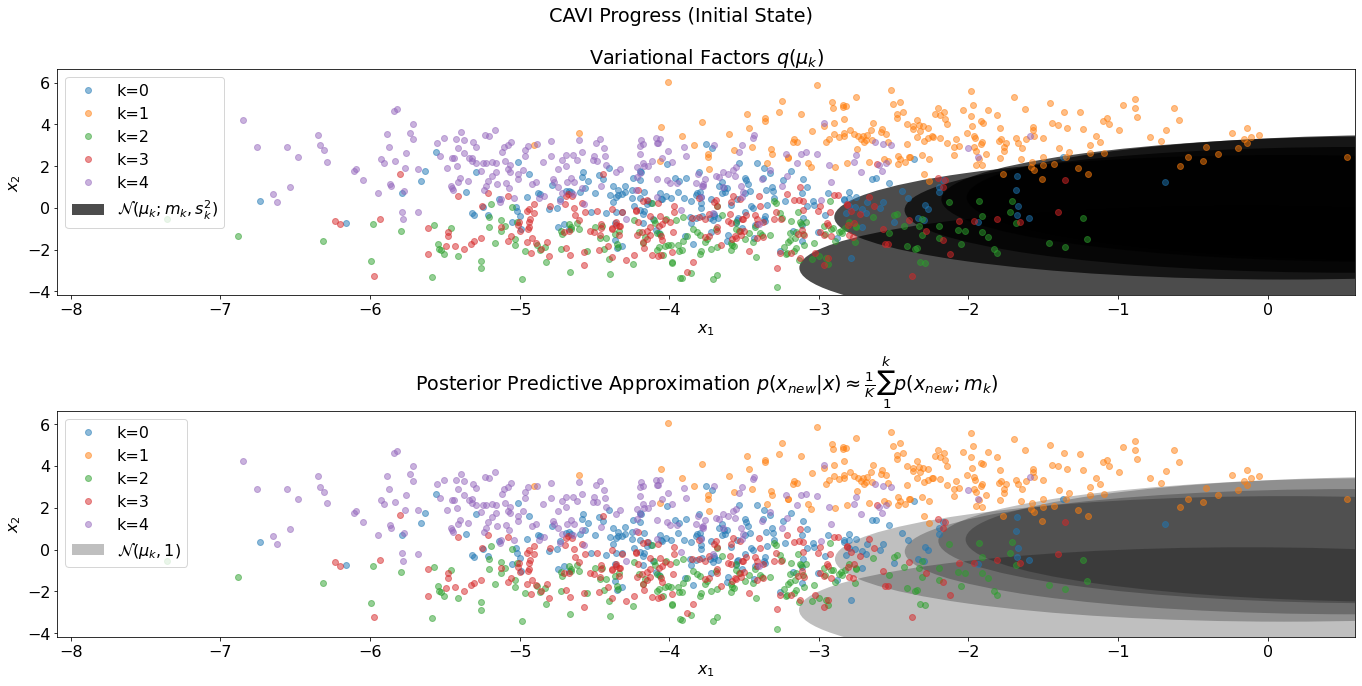

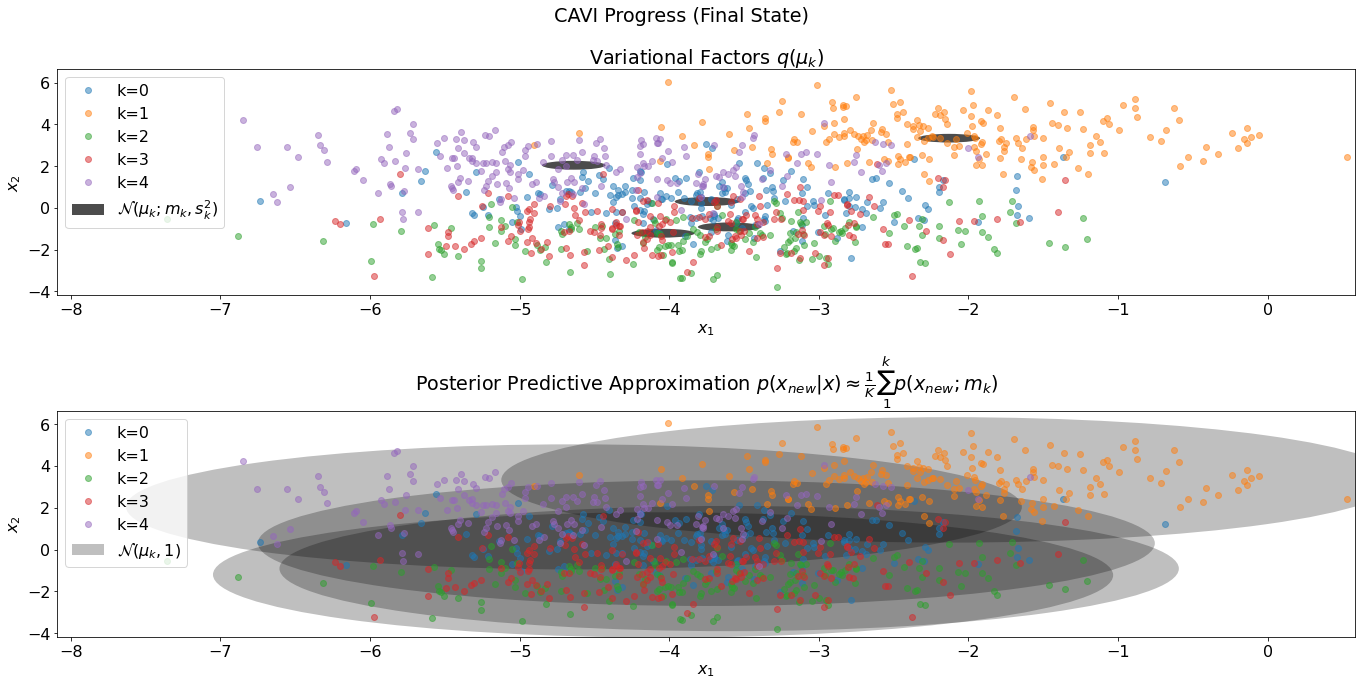

In [8]:
phi, m, s2, debug_data = CAVI(samples)

plotCaviIter(samples, debug_data)  # providing no iteration input plots the initial state
plotCaviIter(samples, debug_data, iter=-1)  # plots the final state


Note that any legal index of the CAVI iteration as input to the plotting function will plot the state at that specific iteration. For example:

(<Figure size 1382.4x703.44 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Variational Factors $q(\\mu_k)$'}, xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:title={'center':'Posterior Predictive Approximation $p(x_{new}|x) \\approx \\frac{1}{K}\\sum_1^kp(x_{new};m_k)$'}, xlabel='$x_1$', ylabel='$x_2$'>],
       dtype=object))

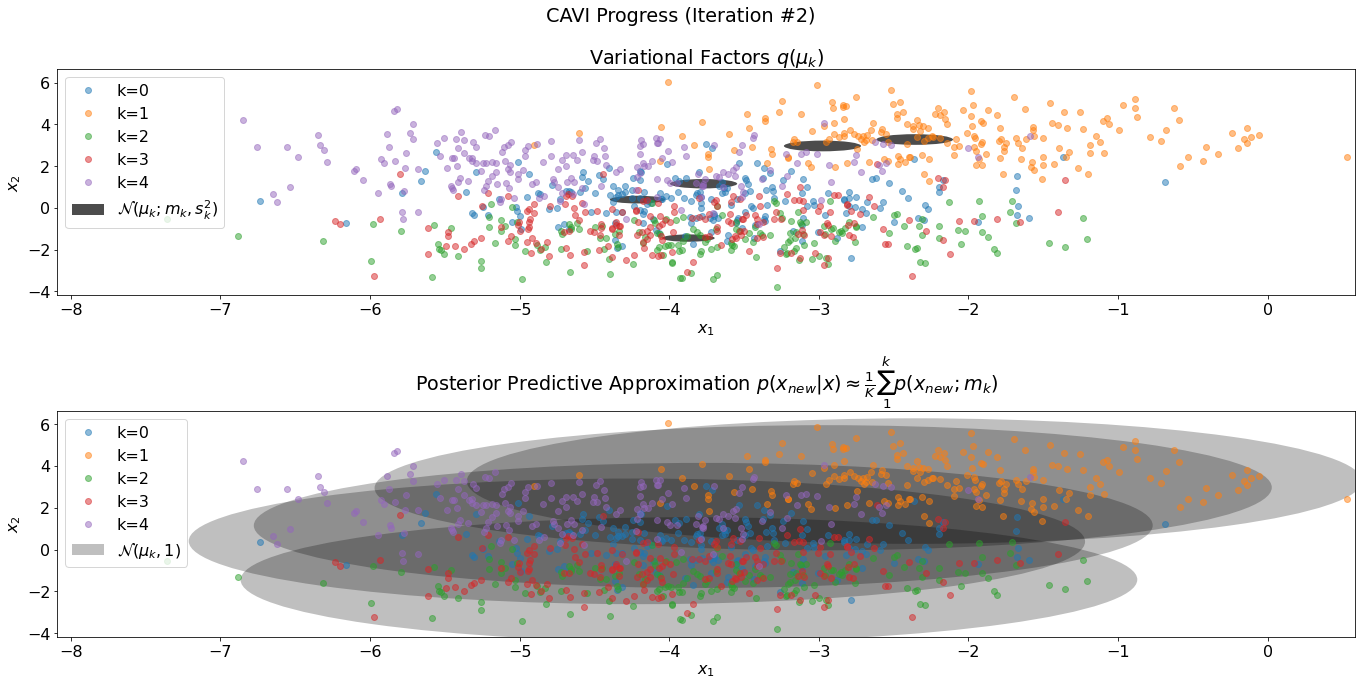

In [9]:
plotCaviIter(samples, debug_data, iter=2)  # plots the final state

We can instead generate a GIF file that captures the progress of the CAVI as it converges:

In [10]:
res_dir = makeGif(samples, debug_data)


Processing CAVI Iterations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:36<00:00,  2.30it/s]


Generating GIF...
GIF is ready!


In [11]:
from pathlib import Path
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
display_gif(Path(res_dir, "ilustration.gif"))


We can additionally inspect the CAVI convergnence by observing the ELBO. Lets perform x10 consequent CAVI maximizations and compare them:

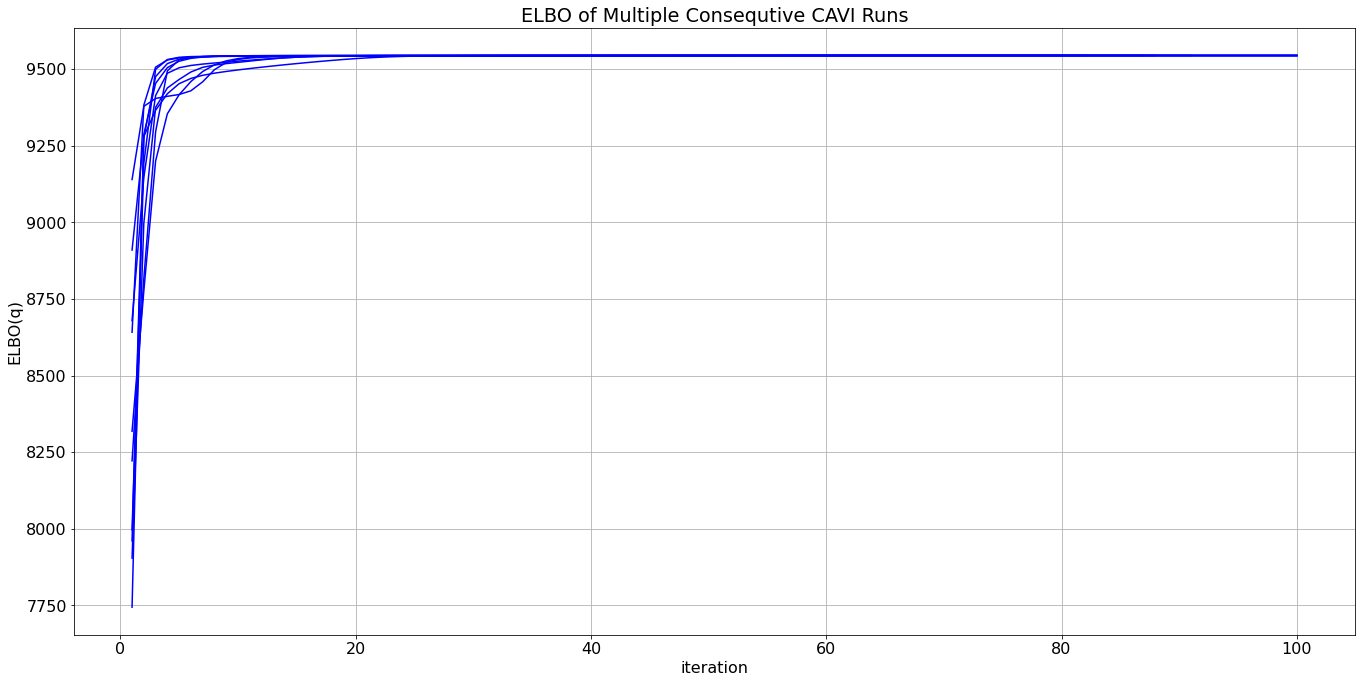

In [12]:
nRuns = 10
elbos = []
fig, ax = plt.subplots()
for run in range(nRuns):
    _, _, _, debug_data = CAVI(samples)
    debug_data.elbo.plot(ax=ax, color="b")
ax.set_xlabel("iteration")
ax.set_ylabel("ELBO(q)")
ax.set_title("ELBO of Multiple Consequtive CAVI Runs")
ax.grid()